# Programming Questions

In general, we are looking for your ability to neatly code up efficient algorithmic ideas. There's no unnecessary burden to make the code look very sophisticated. At the end, neat, efficient and functional code is what we expect.

#### PART 1 

(Expected time to complete: 25 minutes)

Survival analysis is a branch of statistics used for analyzing the expected time duration until an event of interest occurs. In this notebook, we will be working through some concepts in survival analysis in the context of modeling failure times for a hypothetical machine. We denote the time at which this machine fails by $T$, where $T>0$. (You can think of time 0 as the time at which the machine was installed). The Weibull distribution is particularly popular in survival analysis, as it can accurately model the time-to-failure of real-world events and is flexible despite having only two parameters. The distribution of failure times $T$ is given by the following formula:

$$\mathrm{Pr}(T = t) = \frac{k}{l}\left(\frac{t}{l}\right)^{k-1} \exp\left(-\left(\frac{t}{l}\right)^{k}\right)$$

where $k>0$ is known as the *shape* parameter and $l >0$ is known as the *scale* parameter. Several examples of Weibull distributions are plotted in the cell below.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

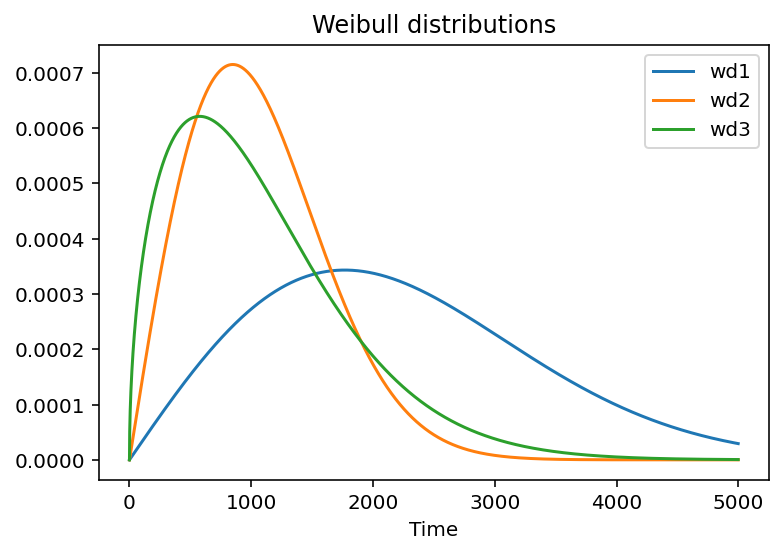

In [3]:
def weibull_dist(t, shape, scale):
    """Returns value of Weibull distribution given parameters.
    Given parameters *shape* and *scale* and input scalar t, returns value at t
    of the Weibull distribution parametrized by *shape* and *scale*."""
    return (shape / scale) * (t / scale)**(shape - 1) * np.exp(-(t / scale)**shape)

# Some examples of Weibull distributions
wd1 = weibull_dist(np.arange(5000), 2, 2500)
wd2 = weibull_dist(np.arange(5000), 2, 1200)
wd3 = weibull_dist(np.arange(5000), 1.5, 1200)
plt.plot(wd1)
plt.plot(wd2)
plt.plot(wd3)
plt.legend(['wd1', 'wd2', 'wd3'])
plt.title("Weibull distributions")
plt.xlabel('Time')
plt.show()

A derived statistic of the Weibull distribution that turns out to be very useful for the purposes of survival analysis is the **hazard function** $h(t)$. The hazard function represents the probability of failure in the next time period $t+1$ given that the asset has survived up until time $t$. For a Weibull model, the hazard function can be written as:

$$h(t) = \mathrm{Pr}({T=t+1|T>t}) = \frac{k}{l}\left(\frac{t}{l}\right)^{k-1}$$

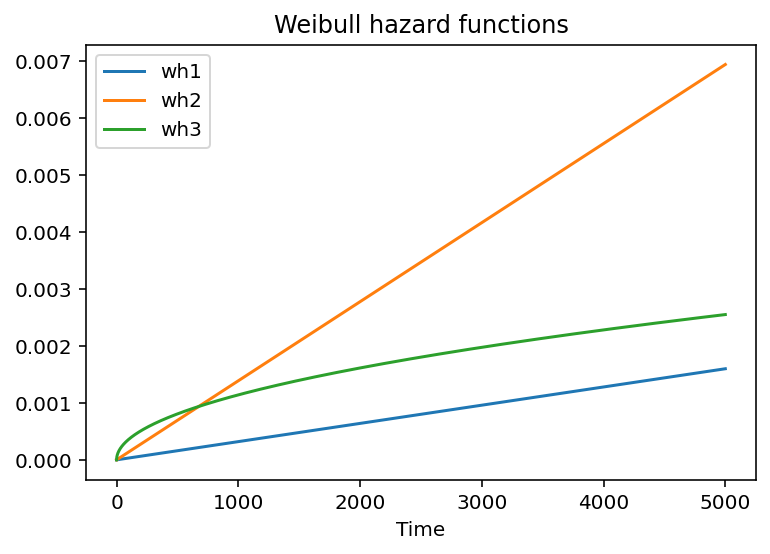

In [4]:
def weibull_hazard(t, shape, scale):
    """Given parameters *shape* and *scale* and input scalar t, returns
    the value at t of the Weibull hazard function parametrized
    by *shape* and *scale*."""
    return (shape / scale) * (t / scale)**(shape - 1)

wh1 = weibull_hazard(np.arange(5000), 2, 2500)
wh2 = weibull_hazard(np.arange(5000), 2, 1200)
wh3 = weibull_hazard(np.arange(5000), 1.5, 1200)
plt.plot(wh1)
plt.plot(wh2)
plt.plot(wh3)
plt.legend(['wh1', 'wh2', 'wh3'])
plt.title("Weibull hazard functions")
plt.xlabel('Time')
plt.show()

Many statistics of interest can be dervied from the hazard function, including:

- Probability of survival until time T
- Probability of failure in a given time horizon

We will be writing functions to implement both of these statistics and exploring how they might be used to predict machine failure.

Perhaps the most intuitive derived statistic of the hazard function is the **survival function** $S(t)$, which tells us the probability that the machine is still in service (e.g. it has not yet failed) at time $t$. Naturally, $S(0) = 1$. The function can be written as

$$S(t) = \mathrm{Pr}(T > t)$$

and can be dervied from the hazard using the formula

$S(t) = \exp(-H(t))$

where the **cumulative hazard function** $H(t)$ is defined as

$H(t) = \int_0^{t}h(\tau)\,\mathrm{d}\tau$

If you noticed how the failure density and the hazard function were created in the cells above, we are not actually generating a continuous function but instead a discrete-time approximation represented as a numpy array. You can think of each time $t$ as a day in the transformer's lifetime. (So the 20th entry of the hazard array is the probability that the machine will fail on day 20 given that it was alive on day 19). Therefore, computing the cumulative hazard $H(t)$ is as simple as computing the sum of the hazard up until time $t$ (there's a nice function in the numpy library for doing this!)


In [5]:
# We'll pick the hazard example plotted in blue in the plots above for our calculations.
hazard = wh1
print(hazard.shape)
print(hazard[0:10])

# TODO: Compute the cumulative hazard function from the hazard.


# TODO: Compute the survival function from hazard and plot it.

(5000,)
[0.00e+00 3.20e-07 6.40e-07 9.60e-07 1.28e-06 1.60e-06 1.92e-06 2.24e-06
 2.56e-06 2.88e-06]


As you might expect, the probability of the machine surviving beyond time $t$ decreases as time goes on. 

Another statistic of interest is the **horizon failure probability**; given that the machine is in service at time $t$, what is the probability that it fails in the next $\delta$ timesteps? This can be expressed as

$$p(t, \delta) = \mathrm{Pr}(T < t + \delta | T \ge t) = 1 - \frac{S(t+\delta)}{S(t)} $$



In [6]:
def horizon_failure_probability(survival, start_time, delta):
  """Compute horizon failure probability.
  Return the probability of failure in the interval.
  (start_time, start_time+delta).

  Arguments:
    survival: a numpy array representing a discrete-time survival function.
    start_time: the time defining the left boundary of the interval
    delta: an integer representing the length of the interval over which to
    compute failure probability.
  """
  # TODO: Implement horizon failure probability.

In [7]:
#horizon_failure_probability(survival, 10, 365)

At this point, you might be wondering what exactly the *point* of all this is. It turns out that using machine learning, we can use data collected during the lifetimes of many machines to train a model that takes in information about a new machine of the same type and returns an estimate of the hazard function for that machine specifically. We can then use this estimated hazard function to compute almost any statistic we'd like, including the horizon failure probability. One thing that might be particularly interesting is to see whether we can predict failure at a certain horizon. That is: given data up until a certain time $t$, how accurately can we predict whether the machine will fail in the next $\delta$ timesteps? For the purposes of this example, we'll choose $\delta =\text{1 year}$.

One approach to implementing this is the following. We start at the beginning of the machine's lifetime, and compute the probability of failure between times $(0, 365)$. Then we compute the probability of failure between $(365, 730)$. And so on... until we reach the end of the transformer's lifetime. Each time, we record whether the actual failure time fell within the interval (this will only be true the last time we do the computation). 

Let's make things a bit more specific. Assume the hazard function we've been working with represents the hazard for each day of a machine's lifetime, and again that **the horizon we're interested in is 1 year = 365 days**). Also assume that based on the manufacturer's records, **this machine failed on day 4000**. The plot below will hopefully make it clear what we'd like to implement:





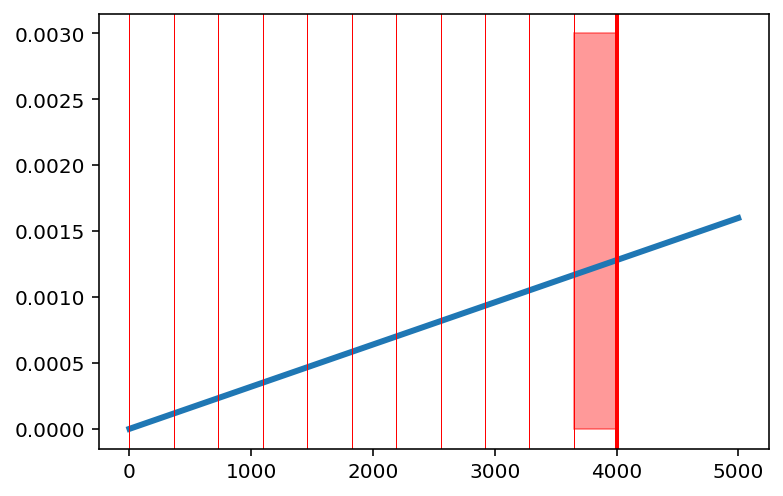

In [8]:
plt.plot(hazard, lw=3)

idxs = [365*i for i in range(4000//365+2)]
for idx in idxs:
  plt.axvline(idx, c='r', lw=0.5)
  
plt.axvline(4000, c='r', lw=2)
plt.fill_betweenx(y=[0,0.003], x1=idxs[-2], x2=idxs[-1], color='r', alpha=0.4)
plt.show()

The last interval highlighted in red (3650, 4015) contains the actual failure (which occurred on day 4000 of it's life, represented by the thick red vertical line), while the spaces between the vertical lines represent each of the intervals over which we're computing the failure probability. Imagine we have 

- a trained model, which given data about a machine outputs a hazard function that accurately models the probability of failure across the machine's lifetime

- a large set of training examples

- a set of test (validation) examples

If we were to compute the failure probability for each year-long interval for each machine in the training set, we might be able to find a threshold $\phi$ that would allow us to build a binary classifier for failure in the next year! We'll come back to this in a second. Right now, we would like to construct a pandas DataFrame that contains failure probabilities and labels of whether a failure actually occurred in each interval (for just one machine).

In [0]:
# You'll probably want to use this function for the task below. It's only
# copied here to remind you of arguments it takes and what it returns.

# def horizon_failure_probability(survival, start_time, delta):
#   """Compute horizon failure probability.

#   Return the probability of failure in the interval 
#   (start_time, start_time+delta)

#   Arguments:
#     survival: a numpy array representing a discrete-time survival function.
#     start_time: the time defining the left boundary of the interval
#     delta: an integer representing the length of the interval in which to 
#     compute failure probability.
#   """

In [36]:
def failure_prob_df(survival, horizon=365, death_time=4000):
  """Given a discrete-time survival function, return a dataframe with
     two columns:

  failure_probs: failure probabilities in the time intervals (0, 365),
  (365, 730), ...
  labels: the label of whether a failure actually occurred in that interval
  (represented by a 0 or a 1).

  Arguments:
    survival: a numpy array representing a discrete-time survival function."""
  # TODO: implement failure_prob_df.

In [11]:
# Example output in case you're still confused:
df = pd.DataFrame({'failure_prob': [0.0, 0.1, 0.2, 0.5],
                    'label': [0, 0, 0, 1]})
df

failure_prob  label
0           0.0      0
1           0.1      0
2           0.2      0
3           0.5      1

In [4]:
# TODO: Compute the failure_df by calling the function and passing in the `survival` function array you computed before
#failure_prob_df(survival, horizon=365, death_time=4000)

Nice work so far!

How might you build a failure prediction classifier at the 1-year horizon, given the setup we've outlined? Remember, you have at your disposal:

- a trained model, which given data about a machine outputs hazard functions that accurately model the probability of failure across the machine's lifetime

- a large set of training examples

- a set of test (validation) examples

and now, 

- a function that takes a survival function for a machine (remember, survival can be easily derived from hazard) and returns a list of failure probabilities at the 1-year horizon, along with the "ground truth" of whether the machine actually failed in that period.

**Hint 1**: For this problem, don't worry too much about the *interpretation* of the failure probability values; all you should be assuming is that higher probabilities indicate it's more likely that a machine will fail in that period. 

**Hint 2**: Remember that threshold $\phi$ we referred to a few cells ago? How could we learn a good value for $\phi$ from all of the machine records in the training data, and use it to see how well we can predict failure for all of the machines in the test data? 

#### PART 2

(Expected time to complete: 20 minutes)

Write a python function that takes an integer n and returns the integer closest to the square root of n, without importing any modules.

In [13]:
def func(n):
    """Finds the integer closest to square root of `n`.

    Args:
        n: reference integer.

    Returns:
        Integer closest to square root of `n`.
    """
    # TODO: Implement me

In [14]:
# TEST CASE
result = [func(n) for n in [12, 1, 0, 36, 98]]

print("Computed: ", result)
print("Expected: ", [3, 1, 0, 6, 10])

Computed:  [None, None, None, None, None]
Expected:  [3, 1, 0, 6, 10]


#### PART 3

(Expected time to complete: 15 minutes)

Problem statement: You have a steady stream of data points coming in, and your objective is to compute the mean of all data samples observed so far, whenever a new data point comes in. Write an "efficient" algorithm to do this.

Note that your function will be called whenever a new data point comes in, and you may choose to record historical information however you may see fit. But, please keep in mind, that the algorithm must be efficient. You can assume this stream to be a consistent, never-ending inflow of points.


In [15]:
# TODO: Implement the function here

In [1]:
# TEST CASE
data = [1.0, 90.7, 45.6, 88.908, 23.678, 5555555.909, 23.56, 41.3, 90.76]
computed = ["REPLACE ME WITH FUNCTION CALL" for n in data]

print("Computed: ", computed)
print("Expected: ", [1.0, 45.85, 45.76666666666667, 56.55200000000001, 49.9772, 925967.6325, 793689.9078571427, 694483.831875])

Computed:  ['REPLACE ME WITH FUNCTION CALL', 'REPLACE ME WITH FUNCTION CALL', 'REPLACE ME WITH FUNCTION CALL', 'REPLACE ME WITH FUNCTION CALL', 'REPLACE ME WITH FUNCTION CALL', 'REPLACE ME WITH FUNCTION CALL', 'REPLACE ME WITH FUNCTION CALL', 'REPLACE ME WITH FUNCTION CALL', 'REPLACE ME WITH FUNCTION CALL']
Expected:  [1.0, 45.85, 45.76666666666667, 56.55200000000001, 49.9772, 925967.6325, 793689.9078571427, 694483.831875]


In [2]:
len(data)

9